<a href="https://colab.research.google.com/github/mhzhao/ML_DYclassification/blob/main/classificationML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. The goal and data used
---

1.   The ultimate goal is to classify Drell Yan ( 𝑒−/𝑒+  pairs) signal from QCD (mainly fake photon pairs, photon-hadron pairs and hadron-hadron pairs) background, instead of going to pair information, we will first focus on the track information which are easier and straightforward task.
2.   The data are from Monte Carlo simulation (Pythia for generator and Geant3 for detectors). The detector system include 3 pre shower layers, FMS and 3 post shower layers, each detectorormation. In principle, the deposited energy in each detector as follows: ![detector response](https://github.com/mhzhao/ML_DYclassification/blob/main/detector_response.png?raw=true)
3.    All the related files are put in my github directory: https://github.com/mhzhao/ML_DYclassification 

4.    Check [classifier comparison](https://colab.research.google.com/drive/1M1sHX2S464-evI9jcPxSo7iWDc8aqIr8?usp=sharing) to get an idea of machine learning algorithm for different problems.


# 2. Traditional way to check features and cuts
---
- Currently the post shower association energy is by 5cm cone from the FMS point, it's not accurate feature to use, so we will first try FMS and pre shower related fetures.
- Our goal is to select **DY** e- and e+, so we will first focus on **track classification**, then we will consider reconstruct the DY($e^-/e^+$) pair as an entity.

## 2.1 Let's first have a look at the features we're going to use

- The data here are tracks information from Pythia simulation, e-/e+ are from DY e-/e+, all others are QCD tracks

In [2]:
# import data from github. Note: in colab, go to Files and refresh to see file or use command !ls to check
# cmd/ctrl + L to clear the output
!wget --quiet https://github.com/mhzhao/ML_DYclassification/blob/main/e-.txt?raw=true
!wget --quiet https://github.com/mhzhao/ML_DYclassification/blob/main/e+.txt?raw=true
!wget --quiet https://github.com/mhzhao/ML_DYclassification/blob/main/pi-.txt?raw=true
!wget --quiet https://github.com/mhzhao/ML_DYclassification/blob/main/pi+.txt?raw=true
!wget --quiet https://github.com/mhzhao/ML_DYclassification/blob/main/K-.txt?raw=true
!wget --quiet https://github.com/mhzhao/ML_DYclassification/blob/main/K+.txt?raw=true
!wget --quiet https://github.com/mhzhao/ML_DYclassification/blob/main/gamma.txt?raw=true
!wget --quiet https://github.com/mhzhao/ML_DYclassification/blob/main/neutron.txt?raw=true
# check them
# !ls -lh

In [ ]:
# rename them
!rename 's/\?raw=true//' *
!ls -lh

In [4]:
# !ls -lh
# load the data
import pandas
allFiles = ["e-.txt","pi-.txt","K-.txt","gamma.txt","neutron.txt"]
liFiles = []
for file in allFiles:
  df = pandas.read_csv(file,index_col=None,header=0)
  liFiles.append(df[0:50000])
orgData = pandas.concat(liFiles,axis=0,ignore_index=True)
# shuffle the data
orgData = orgData.sample(frac=1).reset_index(drop=True)

In [5]:
orgData.describe
orgData.columns

Index(['pointE', 'pointERatio', 'pointEconeRatio', 'fmsPointMulti',
       'clusterSize', 'efpsL1a', 'efpsL2a', 'efpsL3a', 'efpostL1a',
       'efpostL2a', 'efpostL3a', 'efpsL1', 'efpsL2', 'efpsL3', 'efpostL1',
       'efpostL2', 'efpostL3', 'mfpsL1', 'mfpsL2', 'mfpsL3', 'mfpostL1',
       'mfpostL2', 'mfpostL3', 'particle'],
      dtype='object')

In [6]:
# check distributions, select 10000 sample of each particle species
orgData.groupby('particle').describe()

pointE                              ... mfpostL3                  
            count       mean        std   min  ...      25%   50%   75%   max
particle                                       ...                           
K-        50000.0  15.999838   6.367854  10.0  ...     19.0  25.0  31.0  59.0
e-        50000.0  25.102775  13.392545  10.0  ...     11.0  17.0  24.0  61.0
gamma     50000.0  22.408345  12.359386  10.0  ...     17.0  23.0  29.0  63.0
neutron   50000.0  15.124322   5.938772  10.0  ...     21.0  26.0  32.0  61.0
pi-       50000.0  15.950458   6.306946  10.0  ...     19.0  25.0  31.0  61.0

[5 rows x 184 columns]

In [7]:
features = orgData.columns.tolist()
features.remove('particle')

In [8]:
visData = orgData.melt(id_vars=['particle'],value_vars=features,var_name='feature') # rearrange the data to conveniently visualize the data

In [9]:
visData = visData.sample(frac=.05).reset_index(drop=True) # select small portion to visualize them, large dataset takes longer time
visData

,particle,feature,value
0,gamma,efpsL3a,47.84
1,neutron,efpsL3,71.79
2,e-,mfpostL1,29.00
3,K-,fmsPointMulti,23.00
4,pi-,efpsL3,178.67
...,...,...,...
287495,e-,efpostL2,23.19
287496,K-,mfpostL3,23.00
287497,e-,mfpostL3,12.00
287498,neutron,efpsL3a,0.00


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


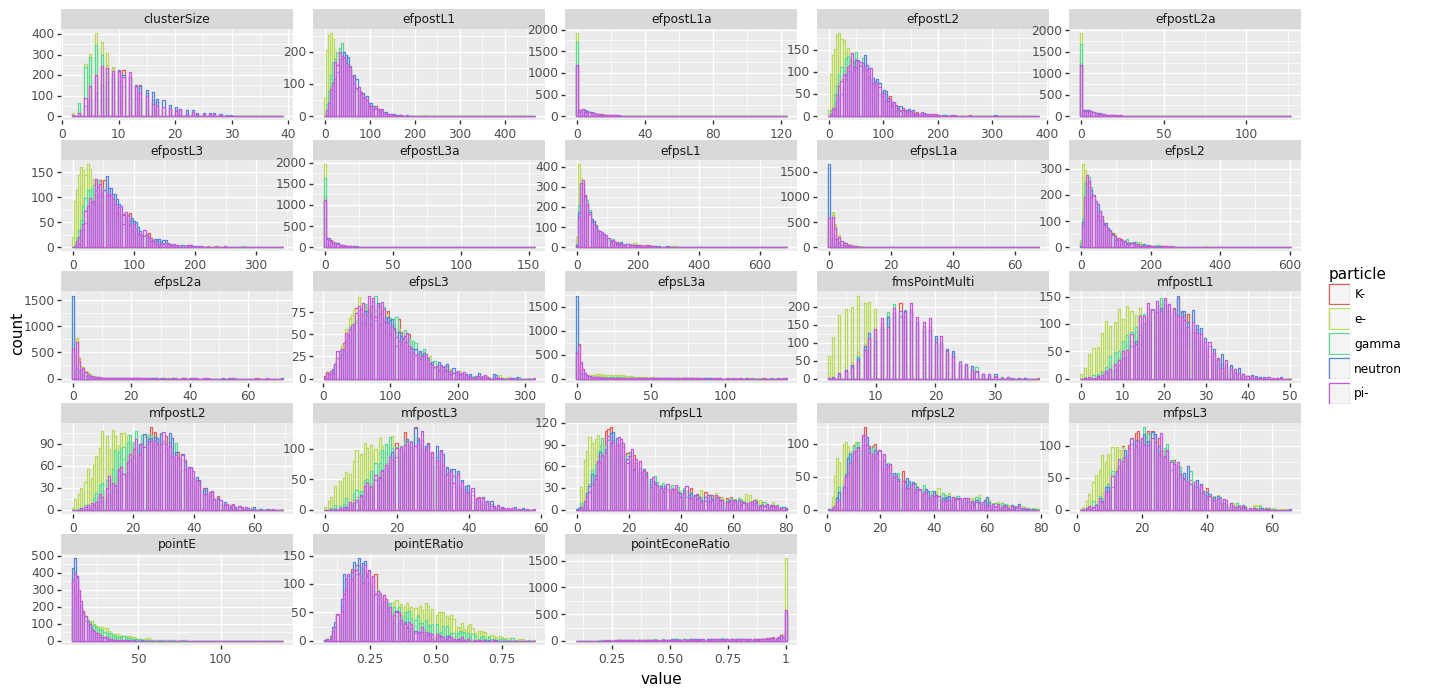

<ggplot: (8775352411873)>

In [10]:
# firstly look at the distribution of each feature
import matplotlib.pyplot as plt
%matplotlib inline
# from plotnine import ggplot, aes, geom_histogram, facet_wrap, facet_grid,theme
from plotnine import *
ggplot(visData,aes(x='value',groupby='particle',color='particle')) + geom_histogram(bins=100,position='identity',fill='white',alpha=0.3) \
+ facet_wrap('feature',scales='free') + theme(figure_size=(16,8),panel_spacing=0.2)

It looks many features useful to distinguish electron from other somehow, we will select some to experiment first, **pointE, pointERatio, pointEconeRatio, clusterSize, fmsPointMulti, efpsL1a, efpsL2a, efpsL3a**

In [11]:
# check these features' correlation
selectFeatures= ['pointE','pointERatio','pointEconeRatio','clusterSize','fmsPointMulti','efpsL1a','efpsL2a','efpsL3a']
corr = orgData[selectFeatures].corr(method='pearson')
corr

,pointE,pointERatio,pointEconeRatio,clusterSize,fmsPointMulti,efpsL1a,efpsL2a,efpsL3a
pointE,1.000000,0.765260,0.202004,0.173570,-0.164247,0.034647,0.036204,0.261543
pointERatio,0.765260,1.000000,0.336881,0.043183,-0.437816,0.036539,0.033262,0.246444
pointEconeRatio,0.202004,0.336881,1.000000,-0.228945,-0.263973,0.027855,0.013766,0.074563
clusterSize,0.173570,0.043183,-0.228945,1.000000,0.130726,0.032728,0.047635,0.002571
fmsPointMulti,-0.164247,-0.437816,-0.263973,0.130726,1.000000,0.005324,0.014064,-0.128055
efpsL1a,0.034647,0.036539,0.027855,0.032728,0.005324,1.000000,0.454898,0.308672
efpsL2a,0.036204,0.033262,0.013766,0.047635,0.014064,0.454898,1.000000,0.363822
efpsL3a,0.261543,0.246444,0.074563,0.002571,-0.128055,0.308672,0.363822,1.000000


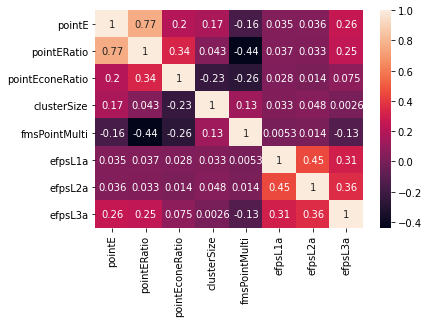

In [12]:
# visualize the correlation
import seaborn as sns;
ax = sns.heatmap(corr,annot=True)

Okay, **pointE** and **pointERatio** has a high correlation, that's imaginable due to we select the higest energy tracks in the event, their ratio also high.

more detailed check of correlation between e-, pi- and gamma as following, I use R code to plot

In [13]:
# more detail check the correlation, start rmagic by executing this 
%load_ext rpy2.ipython

In [14]:
%%R
install.packages("GGally",quiet=1) # you may need to install the needed packages first

R[write to console]: also installing the dependencies ‘plyr’, ‘reshape’




In [20]:
# need load the library first
%%R
library("GGally")

R[write to console]: Loading required package: ggplot2

R[write to console]: Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



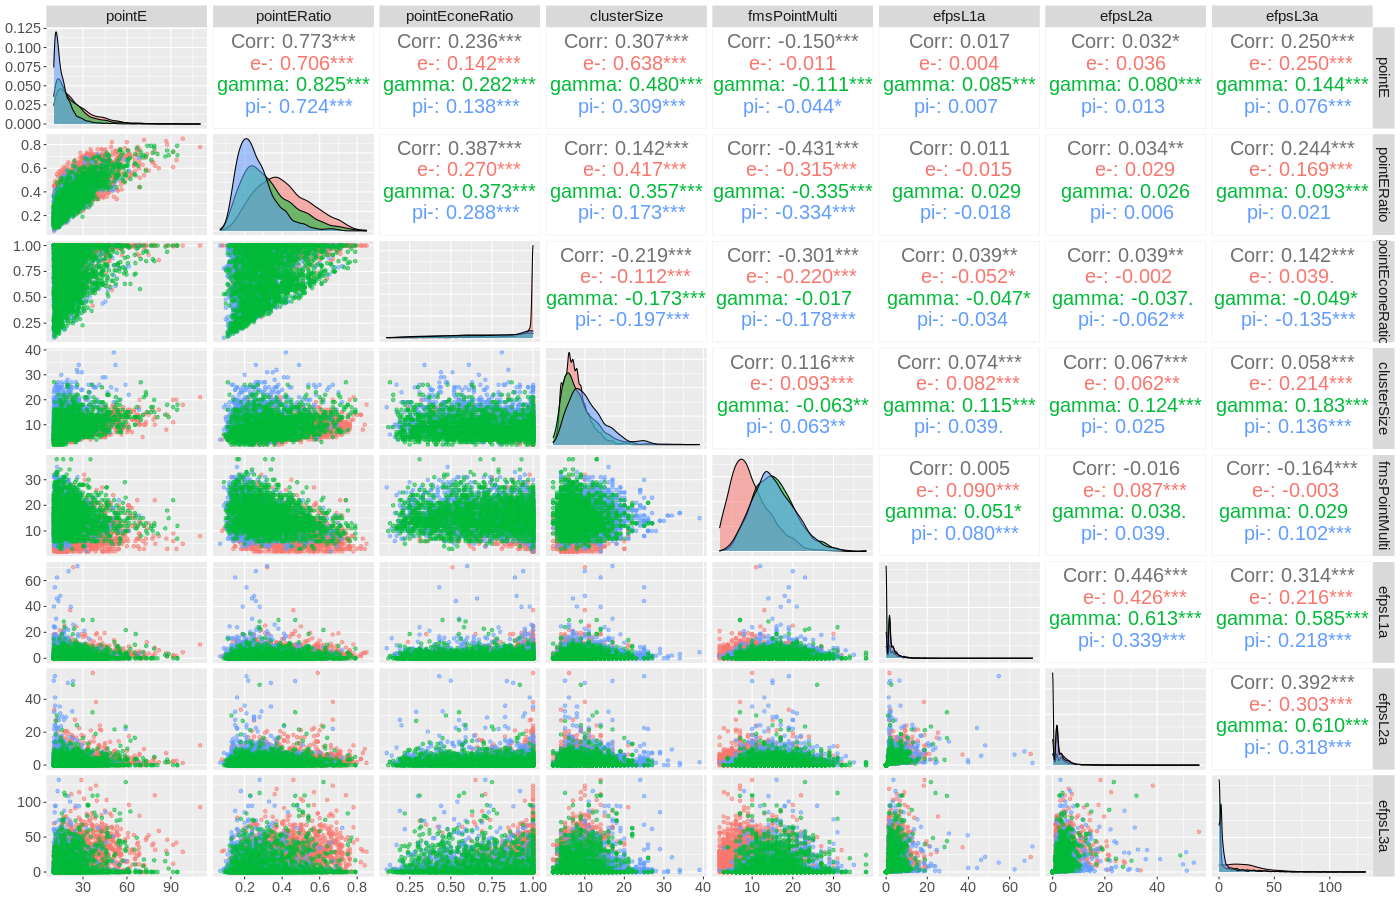

In [21]:
%%R -w 1400 -h 900 -u px # to execute R code, the option are figure size to show
#library("GGally")
#options(repr.plot.width=16, repr.plot.height=11)
electron <- read.csv("https://github.com/mhzhao/ML_DYclassification/blob/main/e-.txt?raw=true")
pion <- read.csv("https://github.com/mhzhao/ML_DYclassification/blob/main/pi-.txt?raw=true")
gamma <- read.csv('https://github.com/mhzhao/ML_DYclassification/blob/main/gamma.txt?raw=true')
allData <- rbind(electron[0:2000,],pion[0:2000,],gamma[0:2000,])
selectFeatures= c('pointE','pointERatio','pointEconeRatio','clusterSize','fmsPointMulti','efpsL1a','efpsL2a','efpsL3a','particle')
allData <- allData[selectFeatures]
corr <- ggpairs(allData,columns = 1:8,ggplot2::aes(color=particle,alpha=0.5),upper = list(continuous = wrap("cor", size = 7)))
corr + theme(strip.text = element_text(size=15),text = element_text(size=18))

Now, let's look at feature by feature to determine cuts to select e-, there are several points to keep in mind
-  electron is charged particles, so the track must be charged track which requires energy deposited in pre shower layer 1, 2 and 3
-  we want high **efficiency** as well as high **purity**
-  for the **purity**, ~~I will use the ratio of background particle divided by signal DY e- and scale them to the same 2017 experimental yield of $500\ pb^{-1}$.~~ I just do signal/(background+signal)

In [61]:
# cuts study
import numpy
# this function return cuts on a feature, signal (e-) efficiency, signal (e-) purity (signal/background)
def efficiency_purity(data: pandas.DataFrame,step: float, lower: float=None, upper: float=None) -> pandas.DataFrame:
  if lower is None:
    lower = min(data.iloc[:,0])
  if upper is None:
    upper = max(data.iloc[:,0])
  cut = []
  effi = []
  purity = []
  feature = []
  sgData = data[data['particle']=='e-']
  bgData = data[data['particle']!='e-']
  for i in numpy.arange(lower if step>0 else upper, upper if step>0 else lower, step):
    cutSg = sgData[sgData.iloc[:,0]>i].shape[0] if step>0 else sgData[sgData.iloc[:,0]<i].shape[0]
    cutBg = bgData[bgData.iloc[:,0]>i].shape[0] if step>0 else bgData[bgData.iloc[:,0]<i].shape[0]
    if((cutSg/sgData.shape[0])>0.01):
      cut.append(i)
      feature.append(sgData.columns[0])
      effi.append(cutSg/sgData.shape[0])
      purity.append(cutSg/(cutBg+cutSg)) 
  effiTable = pandas.DataFrame({'cut':cut,'efficiency':effi,'purity':purity,'feature':feature})
  return effiTable

In [17]:
# get cuts and efficiency on each feature
cutStep = [0.5,0.01,0.01,-1,-1,0.02,0.02,0.02] # negative means the cut will be smaller than a value
cutTable = pandas.DataFrame(columns=['cut','efficiency','purity','feature'])
for ff in selectFeatures:
  cutFeature = orgData[[ff,'particle']]
  idx = selectFeatures.index(ff)
  myTable = efficiency_purity(cutFeature,cutStep[idx])
  cutTable = cutTable.append(myTable,ignore_index=True)

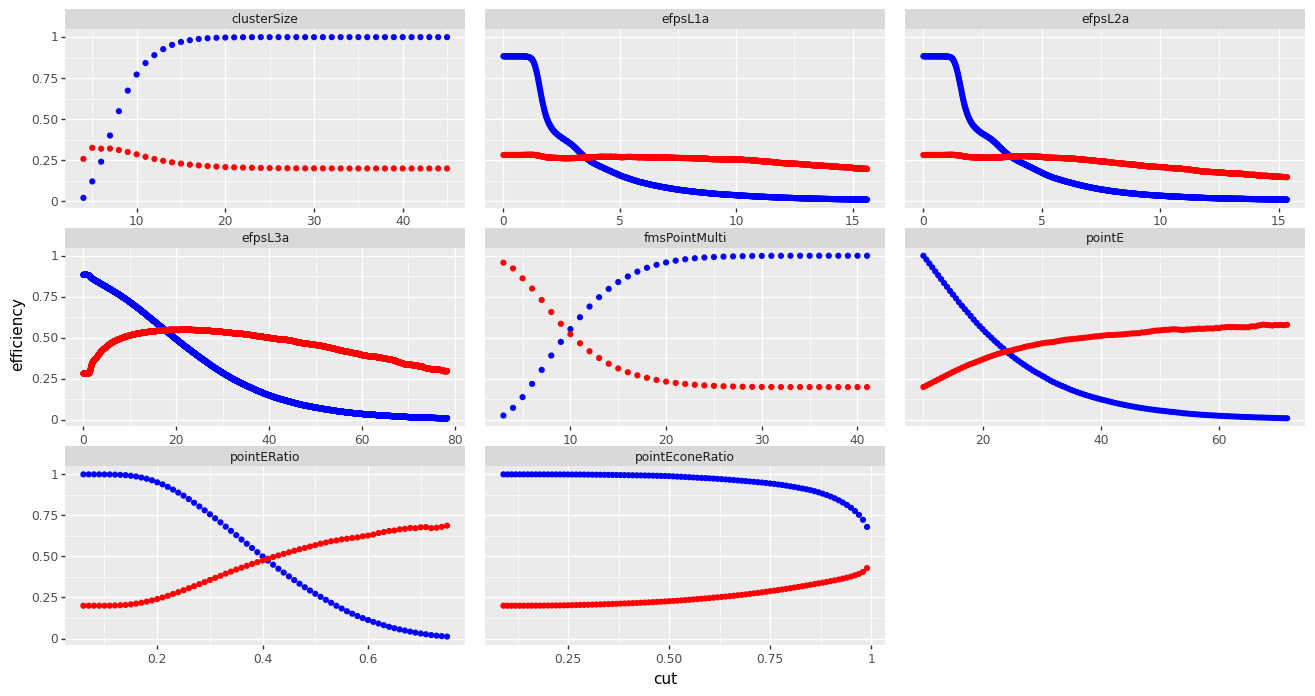

<ggplot: (8775328780077)>

In [18]:
# plot cut vs efficiency and cut vs purity
ggplot(cutTable) + geom_point(aes(x='cut',y='efficiency'),color='blue') + geom_point(aes(x='cut',y='purity'),color='red') \
+ facet_wrap('feature',scales='free_x') + theme(figure_size=(16,8),panel_spacing=0.2,legend_position=(0.5,0.5))

The above figure shows the efficiency (blue) and purity (red) with cut, we will keep high efficiency as priority and give a set of cuts to show you an impression of efficiency. 
- pointE>11.0GeV, efficiency: 0.95314
- pointEconeRatio>0.70, efficiency: 0.95448
- pointERatio>0.20, efficiency: 0.95184
- clusterSize<14, efficiency: 0.95298
- fmsPointMulti<20, efficiency: 0.95916
- efpsL1a>0.8, efficiency: 0.88364
- efpsL2a>0.8, efficiency: 0.88364
- efpsL3a>0.8, efficiency: 0.88364

Now let's execute these sequential cuts to check the final efficiency and purity.


In [62]:
# calculate each species passing through cuts
import numpy as np
cuts = (orgData['pointE']>11)&(orgData['pointEconeRatio']>0.7)&(orgData['pointERatio']>0.2)&(orgData['clusterSize']<14)&(orgData['fmsPointMulti']<20)&(orgData['efpsL1a']>0.8)&(orgData['efpsL2a']>0.8)&(orgData['efpsL3a']>0.8)
particles = [['e-'],['gamma'],['pi-']]
effiTable = pandas.DataFrame(columns=["e-","gamma","pi-"])
passCuts = []
total = []
for particle in particles:
  passCuts.append(orgData[cuts&orgData['particle'].isin(particle)].shape[0])
  total.append(orgData[orgData['particle'].isin(particle)].shape[0])
passCuts = np.array(passCuts)
total = np.array(total)

### The cuts efficiency

In [63]:
efficiencies = passCuts/total
purity = passCuts[0]/(passCuts.sum())
print("by the cuts to recognize e-, gamma and pi- as e-: ({:.2f} {:.2f} {:.2f})".format(efficiencies[0],efficiencies[1], efficiencies[2]))

by the cuts to recognize e-, gamma and pi- as e-: (0.71 0.11 0.24)


## 2.2 check more features to use

In [292]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')
%matplotlib inline
import seaborn as sns
# features = myData.drop(labels=['particle'],axis=1)
plt.figure(figsize=(10,8))
#sns.lineplot(data=features)
#features = ['pointE','pointERatio','pointEconeRatio','fmsPointMulti','clusterSize','efpsL1a','efpsL2a','efpsL3a']

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

# 3. try deep learning

## 3.1 multi-classification

For simplest, I select e-, pi- and gamma, three classes to test

In [227]:
# import the packages we will be using
import numpy as np
import tensorflow as tf
import pylab as plt

In [228]:
import pandas
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [229]:
myData = orgData[(orgData['particle']=='e-') | (orgData['particle']=='gamma') | (orgData['particle']=='pi-')]
myData = myData.sample(frac=1.0).reset_index(drop=True)

In [230]:
myData.describe
myData.columns

Index(['pointE', 'pointERatio', 'pointEconeRatio', 'fmsPointMulti',
       'clusterSize', 'efpsL1a', 'efpsL2a', 'efpsL3a', 'efpostL1a',
       'efpostL2a', 'efpostL3a', 'efpsL1', 'efpsL2', 'efpsL3', 'efpostL1',
       'efpostL2', 'efpostL3', 'mfpsL1', 'mfpsL2', 'mfpsL3', 'mfpostL1',
       'mfpostL2', 'mfpostL3', 'particle'],
      dtype='object')

In [231]:
# choose the features and target
particle_features = ['pointE','pointERatio','pointEconeRatio','fmsPointMulti','clusterSize','efpsL1a','efpsL2a','efpsL3a']
target = ['particle']
X = myData[particle_features].astype(float)
Y = myData.particle

In [232]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

X_train, X_test, y_train, y_test = train_test_split(X,dummy_y,test_size=0.3)

# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(8, input_dim=8, activation='relu'))
	model.add(Dense(8, activation='relu'))
	model.add(Dense(8, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# cross validation the model
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=1000, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)

In [233]:
results = cross_val_score(estimator, X_train, y_train, cv=kfold) 
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 77.88% (0.45%)


In [234]:
# normalize the train data, normally it makes better
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
clf = make_pipeline(preprocessing.StandardScaler(),estimator)
resultss = cross_val_score(clf, X_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (resultss.mean()*100, resultss.std()*100))

Baseline: 78.39% (0.48%)


In [235]:
# as we can see, rescale the train data giving better result, so choose it to train the model 
history = clf.fit(X_train, y_train)

In [236]:
clf.score(X_test,y_test)

0.781000018119812

### The model evaluation

In [247]:
y_pred = clf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [253]:
y_pred = np_utils.to_categorical(y_pred)

In [254]:
# more check
from sklearn.metrics import classification_report
# e- -> 0, gamma -> 1, pi- -> 2
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83     15053
           1       0.73      0.76      0.74     14985
           2       0.79      0.76      0.77     14962

   micro avg       0.78      0.78      0.78     45000
   macro avg       0.78      0.78      0.78     45000
weighted avg       0.78      0.78      0.78     45000
 samples avg       0.78      0.78      0.78     45000



-  Precision — What percent of your predictions were correct
-  Recall — What percent of the positive cases did you catch
-  F1 score — What percent of positive predictions were correct
-  Support — The number of actual occurrences of the class in the specified dataset
-  Check more: [Understanding a Classification Report For Your Machine Learning Model](https://colab.research.google.com/drive/17x_kZ2j-G2HzAw4OSRObni7rnRfPTCMB?usp=sharing)

In [259]:
# check e- prediction on each species
predList = []
for i in range(3):
  pred = clf.predict(X_test[y_test[:,i]==1.])
  electron = np.count_nonzero(pred==0)
  total = np.count_nonzero(y_test[:,i]==1)
  predList.append(electron/total)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses

In [260]:
print("the model to classify e-, gamma and pi- as e-: ({:.2f} {:.2f} {:.2f})".format(predList[0],predList[1], predList[2]))

the model to classify e-, gamma and pi- as e-: (0.83 0.11 0.07)


## 3.2. try binary classification of deep learning

e- and gamma, two classes

In [206]:
# try binary classification
allFiles = ['/content/e-.txt',
            '/content/gamma.txt'
            ]
liFiles = []
for file in allFiles:
  df = pandas.read_csv(file,index_col=None,header=0)
  liFiles.append(df)
myData = pandas.concat(liFiles,axis=0,ignore_index=True)
# shuffle the data
myData = myData.sample(frac=1).reset_index(drop=True)

# choose the features and target
particle_features = ['pointE','pointERatio','pointEconeRatio','fmsPointMulti','clusterSize','efpsL1a','efpsL2a','efpsL3a']
target = ['particle']
X = myData[particle_features]
Y = myData.particle
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from tensorflow.keras import layers

# hold out a set as test
X_model, X_test, y_model, y_test = train_test_split(X,Y,train_size=0.9)
# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = train_test_split(X_model, y_model, stratify=y_model, train_size=0.8)

input_shape = [X_train.shape[1]]

In [207]:
# define the model
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(units=8,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(units=8,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(units=8,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(units=1,activation='sigmoid')
])


In [208]:
#  Add Optimizer, Loss, and Metric
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)


In [209]:
# adjust capacity and early stopping to avoid under or over fitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

# build the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

Epoch 1/200
282/282 [==============================] - 2s 4ms/step - loss: 0.6827 - binary_accuracy: 0.6416 - val_loss: 0.3831 - val_binary_accuracy: 0.8501
Epoch 2/200
282/282 [==============================] - 1s 3ms/step - loss: 0.4504 - binary_accuracy: 0.8156 - val_loss: 0.3411 - val_binary_accuracy: 0.8635
Epoch 3/200
282/282 [==============================] - 1s 3ms/step - loss: 0.4138 - binary_accuracy: 0.8336 - val_loss: 0.3328 - val_binary_accuracy: 0.8663
Epoch 4/200
282/282 [==============================] - 1s 3ms/step - loss: 0.3952 - binary_accuracy: 0.8439 - val_loss: 0.3279 - val_binary_accuracy: 0.8671
Epoch 5/200
282/282 [==============================] - 1s 3ms/step - loss: 0.3876 - binary_accuracy: 0.8464 - val_loss: 0.3242 - val_binary_accuracy: 0.8681
Epoch 6/200
282/282 [==============================] - 1s 3ms/step - loss: 0.3754 - binary_accuracy: 0.8524 - val_loss: 0.3225 - val_binary_accuracy: 0.8688
Epoch 7/200
282/282 [==============================] - 1s 

In [210]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

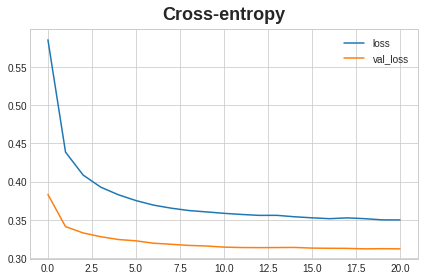

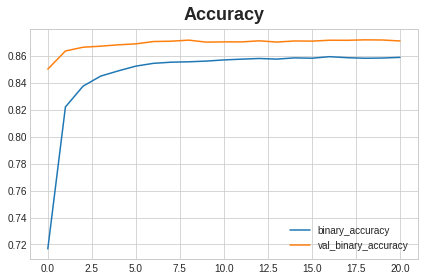

In [211]:
# plot to monitor the quality
history_df = pandas.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

### The model evaluation

In [220]:
y_pred = (model.predict(X_test)>0.5).astype("int32")

In [223]:
# more check
from sklearn.metrics import classification_report
# e- -> 0, gamma -> 1
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     10040
           1       0.86      0.88      0.87      9960

    accuracy                           0.87     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000



In [224]:
# the encode, e- -> 0, gamma -> 1
preds = []
for i in range(2):
  pred = (model.predict(X_test[y_test==i])>0.5).astype("int32")
  electron = np.count_nonzero(pred==0)
  total = np.count_nonzero(y_test==i)
  preds.append(electron/total)

In [226]:
print("the model classify e-, gamma as e-: ({:.2f} {:.2f})".format(preds[0],preds[1]))

the model classify e-, gamma as e-: (0.86 0.12)


# 4. try tree methods

## 4.1. Random forest

In [195]:
# load data
allFiles = ['/content/e-.txt','/content/pi-.txt',
            '/content/gamma.txt'
            ]
liFiles = []
for file in allFiles:
  df = pandas.read_csv(file,index_col=None,header=0)
  liFiles.append(df)
myData = pandas.concat(liFiles,axis=0,ignore_index=True)
# shuffle the data
myData = myData.sample(frac=1).reset_index(drop=True)
# choose the features and target
particle_features = ['pointE','pointERatio','pointEconeRatio','fmsPointMulti','clusterSize','efpsL1a','efpsL2a','efpsL3a']
target = ['particle']
X = myData[particle_features].astype(float)
X.shape
#X = X.values
Y = myData.particle
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

X_train, X_test, y_train, y_test = train_test_split(X,Y,stratify=Y,test_size=0.2)

In [196]:
# train the model
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=1000,max_depth=8, random_state=0).fit(X_train,y_train)

In [215]:
# test the model
y_pred = RF.predict(X_test)
round(RF.score(X_test,y_test),4)

0.7899

### The model evaluation

In [200]:
# more check
from sklearn.metrics import classification_report
# e- -> 0, gamma -> 1, pi- -> 2
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83     20000
           1       0.72      0.75      0.74     20000
           2       0.78      0.74      0.76     20000

    accuracy                           0.77     60000
   macro avg       0.78      0.77      0.77     60000
weighted avg       0.78      0.77      0.77     60000



In [204]:
# the encode, e- -> 0, gamma -> 1, pi- -> 2
predss = []
for i in range(3):
  pred = RF.predict(X_test[y_test==i])
  electron = np.count_nonzero(pred==0)
  total = np.count_nonzero(y_test==i)
  predss.append(electron/total)

In [205]:
print("the model classify on e-, gamma and pi- as e-: ({:.2f} {:.2f} {:.2f})".format(predss[0],predss[1],predss[2]))

the model classify on e-, gamma and pi- as e-: (0.83 0.11 0.07)


## 4.2. xgboost

In [176]:
# load data
allFiles = ['/content/e-.txt','/content/pi-.txt',
            '/content/gamma.txt'
            ]
liFiles = []
for file in allFiles:
  df = pandas.read_csv(file,index_col=None,header=0)
  liFiles.append(df)
myData = pandas.concat(liFiles,axis=0,ignore_index=True)
# shuffle the data
myData = myData.sample(frac=1).reset_index(drop=True)
# choose the features and target
particle_features = ['pointE','pointERatio','pointEconeRatio','fmsPointMulti','clusterSize','efpsL1a','efpsL2a','efpsL3a']
target = ['particle']
X = myData[particle_features].astype(float)
X.shape
#X = X.values
Y = myData.particle
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

X_train, X_test, y_train, y_test = train_test_split(X,Y,stratify=Y,test_size=0.2)

In [177]:
# try xgboost
from xgboost import XGBClassifier
myModel = XGBClassifier(max_depth=8,n_estimators=500,learning_rate=0.05,n_jobs=4,objective='multi:softprob',random_state=0)

In [178]:
results = myModel.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],eval_metric='mlogloss',early_stopping_rounds=10,verbose=0)

In [179]:
ev_result = myModel.evals_result()

In [180]:
# check test accurate
myModel.score(X_test,y_test)

0.78915

In [181]:
y_pred = myModel.predict(X_test)

In [182]:
myModel.predict_proba(X_test)

array([[9.99291420e-01, 5.72095334e-04, 1.36405986e-04],
       [9.73998427e-01, 2.50690244e-02, 9.32538183e-04],
       [9.17529404e-01, 3.79112363e-02, 4.45593223e-02],
       ...,
       [2.79893070e-01, 6.53061688e-01, 6.70452565e-02],
       [9.53511596e-01, 3.46774794e-02, 1.18109025e-02],
       [1.68017577e-02, 9.51080084e-01, 3.21182050e-02]], dtype=float32)

### The model evaluation

In [183]:
# more check
from sklearn.metrics import classification_report
# e- -> 0, gamma -> 1, pi- -> 2
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83     20000
           1       0.74      0.76      0.75     20000
           2       0.80      0.77      0.78     20000

    accuracy                           0.79     60000
   macro avg       0.79      0.79      0.79     60000
weighted avg       0.79      0.79      0.79     60000



In [192]:
predd = []
for i in range(3):
  pred = myModel.predict(X_test[y_test==i])
  electron = np.count_nonzero(pred==0)
  total = np.count_nonzero(y_test==i)
  predd.append(electron/total)

In [193]:
print("the model classify e-, gamma and pi- as e-: ({:.2f} {:.2f} {:.2f})".format(predd[0],predd[1], predd[2]))

the model classify e-, gamma and pi- as e-: (0.84 0.11 0.07)


## more details about the model

In [ ]:
import xgboost

In [12]:
myModel.feature_importances_

array([0.05914062, 0.08786153, 0.20332943, 0.11394759, 0.12195656,
       0.08693254, 0.09009994, 0.23673186], dtype=float32)

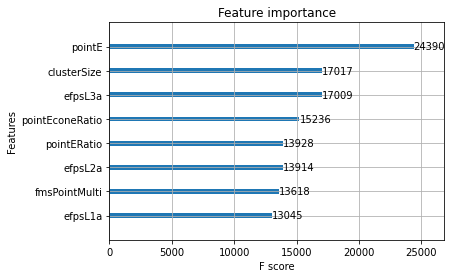

In [13]:
# show the feature importance
xgboost.plot_importance(myModel)

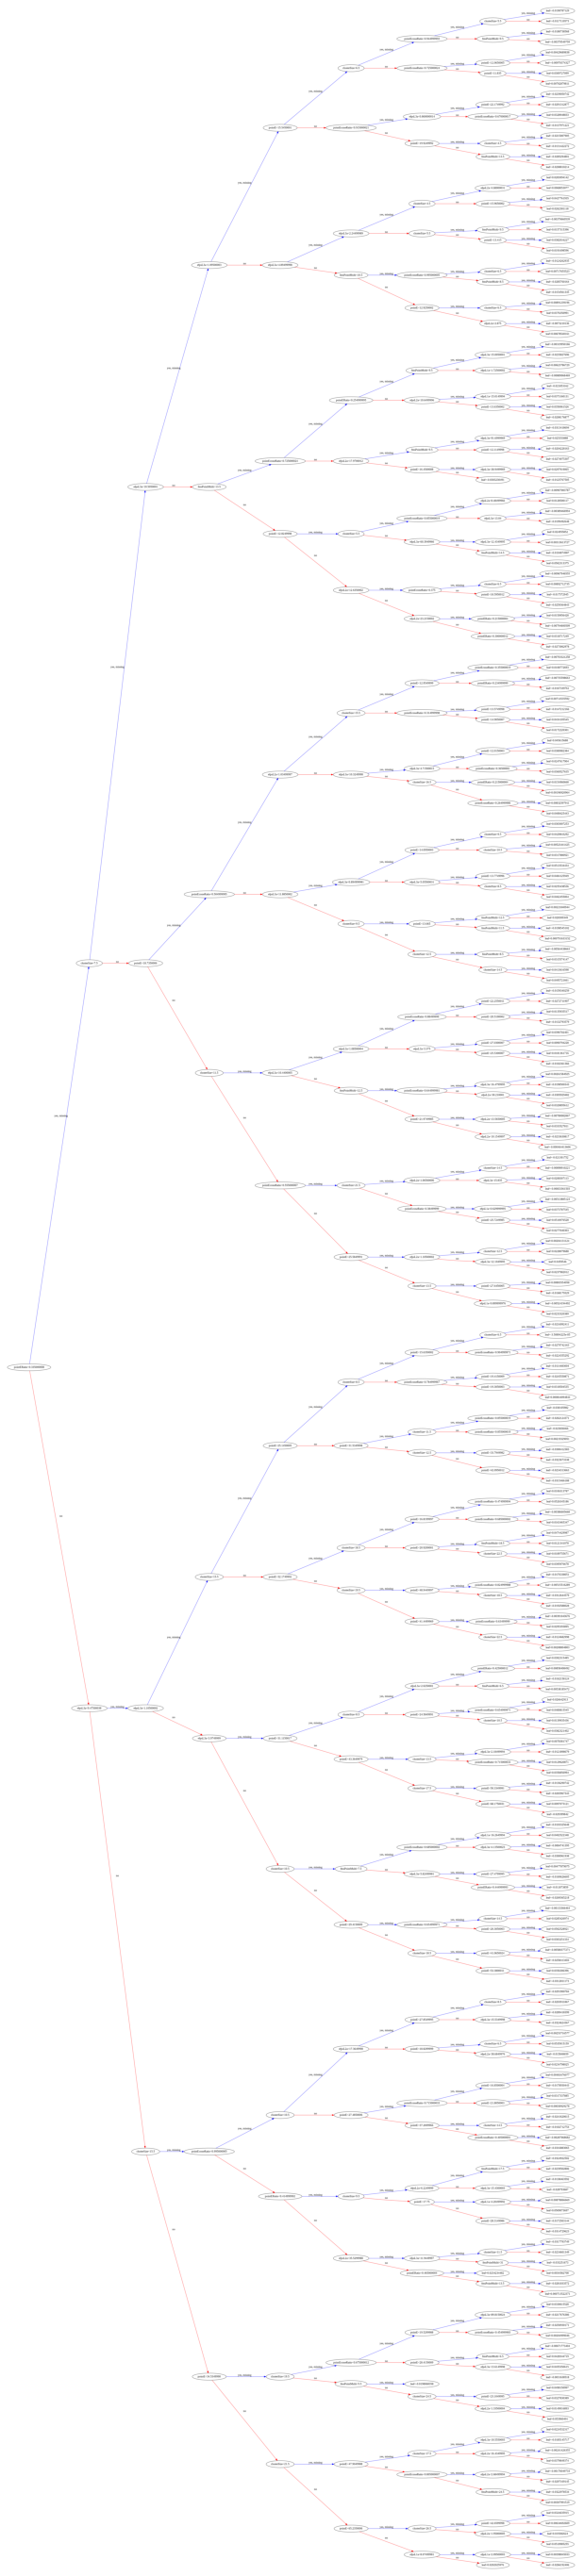

In [16]:
# show a tree
xgboost.plot_tree(myModel,num_trees=0, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(25, 50)
fig.show()